In [2]:
from utils.binaries import *
from utils.plotting import *

import os 

16:59:06 (  +49.2s) [INFO   ] -- import logging
16:59:06 (  +115ms) [INFO   ] -- import numpy as np
16:59:06 (    +9ms) [INFO   ] -- import uncertainties
16:59:07 (  +232ms) [INFO   ] -- import pandas as pd
16:59:07 (    +2ms) [WARNING] -- pandas support to be dropped at some point!
16:59:07 (    +2ms) [INFO   ] -- import binaries.tools as tools
16:59:07 (  +306ms) [INFO   ] -- import matplotlib.pyplot as plt
16:59:07 (  +444ms) [INFO   ] -- import seaborn as so
16:59:07 (   +11ms) [DEBUG  ] -- font size set to 9.5
16:59:07 (    +1ms) [DEBUG  ] -- label size set to 13.0
16:59:07 (    +1ms) [DEBUG  ] -- figure size set to [6.6, 3.3]
16:59:07 (    +0ms) [DEBUG  ] -- markersize set to 2.0
16:59:07 (    +1ms) [DEBUG  ] -- usetex set to False
16:59:07 (    +2ms) [INFO   ] -- import plotting.tools as plot


In [27]:
from scipy.optimize import curve_fit

def parabola(x, a, mip, height):
    return a*(x - mip)**2 + height

def get_signal(peak_histo, station):

    extract = {
        '643' : lambda x : x[np.argmax(peak_histo)-10 : np.argmax(peak_histo) + 10],
        '659' : lambda x : x[np.argmax(peak_histo)-10 : np.argmax(peak_histo) + 10],
        '660' : lambda x : x[np.argmax(peak_histo[2:])-10 : np.argmax(peak_histo[2:]) + 10],
        '1823' : lambda x : x[np.argmax(peak_histo)-10 : np.argmax(peak_histo) + 10],
        '1840' : lambda x : x[np.argmax(peak_histo)-10 : np.argmax(peak_histo) + 10],
        '1844' : lambda x : x[np.argmax(peak_histo)-10 : np.argmax(peak_histo) + 10],
        '1845' : lambda x : x[np.argmax(peak_histo)-10 : np.argmax(peak_histo) + 10],
        '1839' : lambda x : x[np.argmax(peak_histo)-10 : np.argmax(peak_histo) + 10],
    }

    return extract[station]


def read_file(path, directory):

    path = f'/cr/users/filip/Data/muonAcquisition/{directory}/' + path
    all_hist = lambda x : [int(e.split(' ')[-1]) for e in x]
    coinc_hist = lambda x : [int(e.split(' ')[-4]) for e in x] # ...
    peak_histo, rates = [], []

    with open(path, 'r') as source:

        baseline = 0

        is_peak_histogram = False
        is_all_histogram = False
        for i, line in enumerate(source.readlines()):
            line = line.strip()

            if line.startswith('Offset'):
                baseline = int(line.split(' ')[-1])

            if line == 'Peak': 
                is_peak_histogram = True
                continue
            elif line == 'Charge':
                is_peak_histogram = False
            
            if is_peak_histogram: peak_histo.append(line)
            if line == '======ssd:':
                is_all_histogram = True
                continue

            if is_all_histogram: rates.append(line)
            
        bin0 = int(rates[0].split(' ')[3])

        ADC_bin_edges = np.array([2*k for k in range(100)] + [200 + 8*k for k in range(51)])
        x_peak_histo = 0.5 * (ADC_bin_edges[1:] + ADC_bin_edges[:-1])
        peak_histo = np.array(coinc_hist(peak_histo))


        signal = get_signal(peak_histo, path.split('_')[1])
        (curve, mip, height), pcov = curve_fit(parabola, signal(x_peak_histo), signal(peak_histo),
                                bounds=([-np.inf, 0, 0],[0, np.inf, np.inf]),
                                maxfev=10000,
                                p0=[-1, 50, 2000])

    return peak_histo, np.cumsum(all_hist(rates[1:])[::-1])[::-1] / 60, bin0 - baseline, mip

1713986545_660
1713986547_1845
1713986548_643
1713986549_1844
1713986549_659
1713986804_1844
1713986804_1845
1713986804_643
1713986804_659
1713986804_660


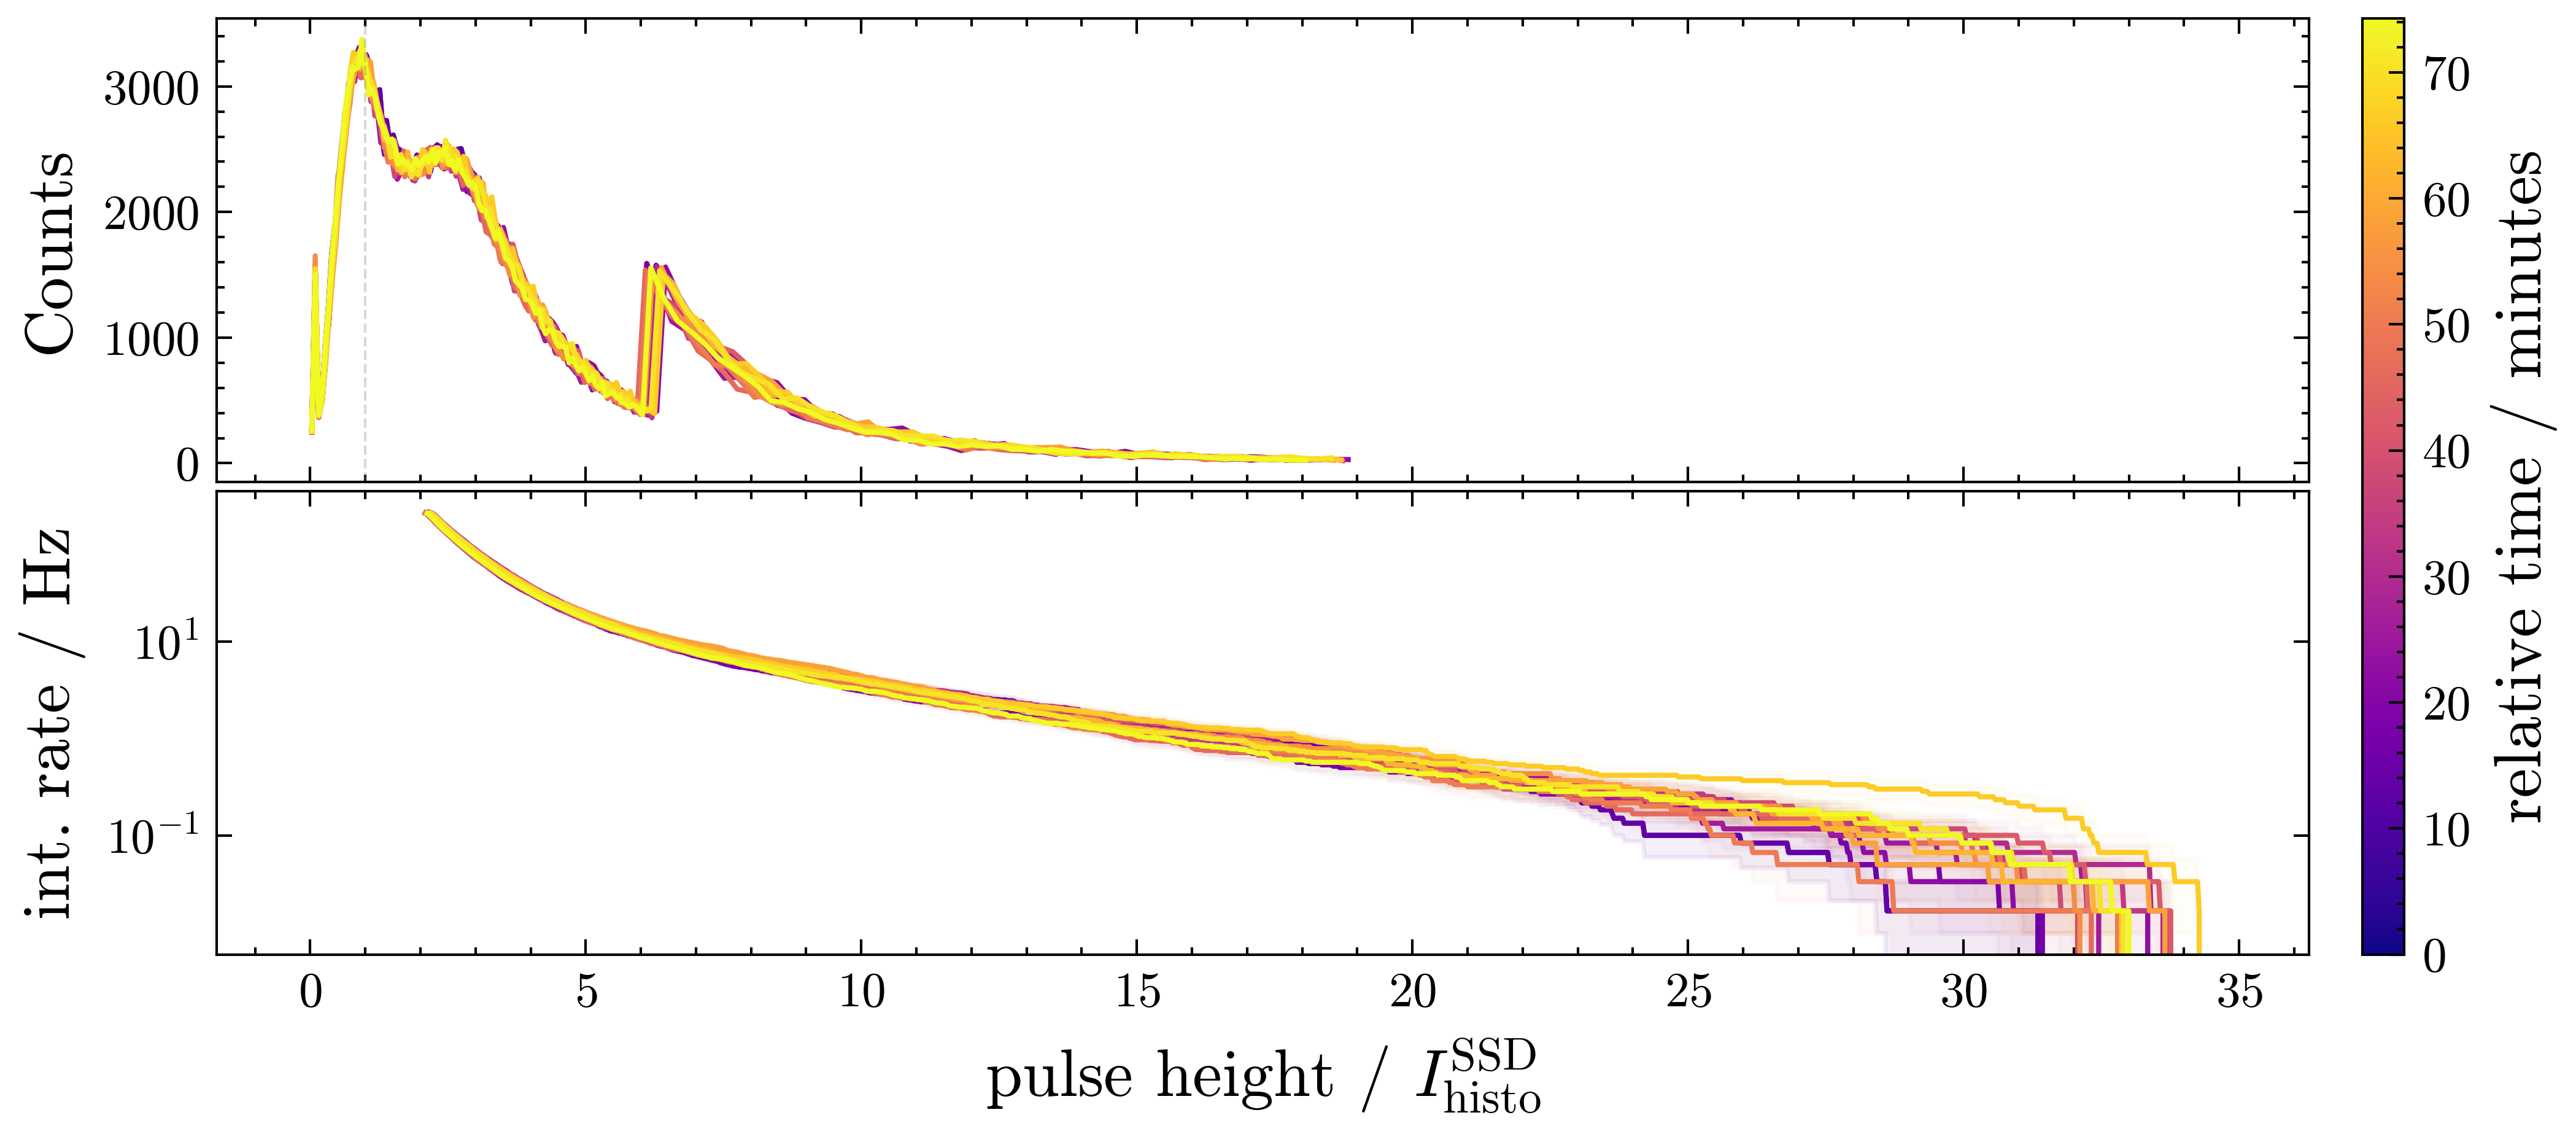

In [28]:
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import ColorbarBase

fig = plt.figure()

gs = GridSpec(
    2,
    2,
    figure=fig,
    width_ratios=[1,0.02],
)
gs.update(left=0.05, right=0.95, wspace=0.05, hspace=0.02)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
cax = fig.add_subplot(gs[:, 1])

ADC_bin_edges = np.array([2*k for k in range(100)] + [200 + 8*k for k in range(51)])
x_peak_histo = 0.5 * (ADC_bin_edges[1:] + ADC_bin_edges[:-1])


mips, rates = {'day' : {}, 'night' : {}}, {'day' : {}, 'night' : {}}

for directory in ['night', 'day']:
    timestamps = [int(file.split('_')[0]) for file in os.listdir(f'/cr/users/filip/Data/muonAcquisition/{directory}/')]
    norm = Normalize(0, (max(timestamps) - min(timestamps)) / 60)

    for i, file in enumerate(os.listdir(f'/cr/users/filip/Data/muonAcquisition/{directory}/')):

        # if file.endswith('660'): continue
        # if file.endswith('1839'): continue

        color = plt.get_cmap('plasma')((norm(timestamps[i] - min(timestamps))) / 60)

        try:
            peak_hist, rate, offset, mip = read_file(file, directory)
            rates[directory][file.split('_')[1]].append({'offset' : offset, 'mip' : mip, 'rate' : rate})
            mips[directory][file.split('_')[1]].append(mip)
        except ValueError:
            print(file)
            continue
        except KeyError:
            rates[directory][file.split('_')[1]] = [{'offset' : offset, 'mip' : mip, 'rate' : rate}]
            mips[directory][file.split('_')[1]] = [mip]

        if not (file.endswith('1839') and directory == 'day'): continue

        ax1.plot(x_peak_histo / mip, peak_hist, c = color, ls='solid')
        ax2.plot(range(offset, offset + len(rate)) / mip, rate, c = color, ls='solid')
        ax2.fill_between(range(offset, offset + len(rate)) / mip, 
                        rate - np.sqrt(rate/60), rate + np.sqrt(rate/60), 
                        color = color,
                        alpha=0.03,)

ax1.axvline(1, c = 'gray', ls = '--', alpha=0.3, lw=0.5)
ax2.set_xlabel('pulse height / $I^\mathrm{SSD}_\mathrm{histo}$')
ax1.set_ylabel('Counts')
ax2.set_ylabel('int. rate / Hz')
ax2.set_yscale('log')

ColorbarBase(cax, cmap='plasma', norm=norm, 
            orientation='vertical',
            label='relative time / minutes')

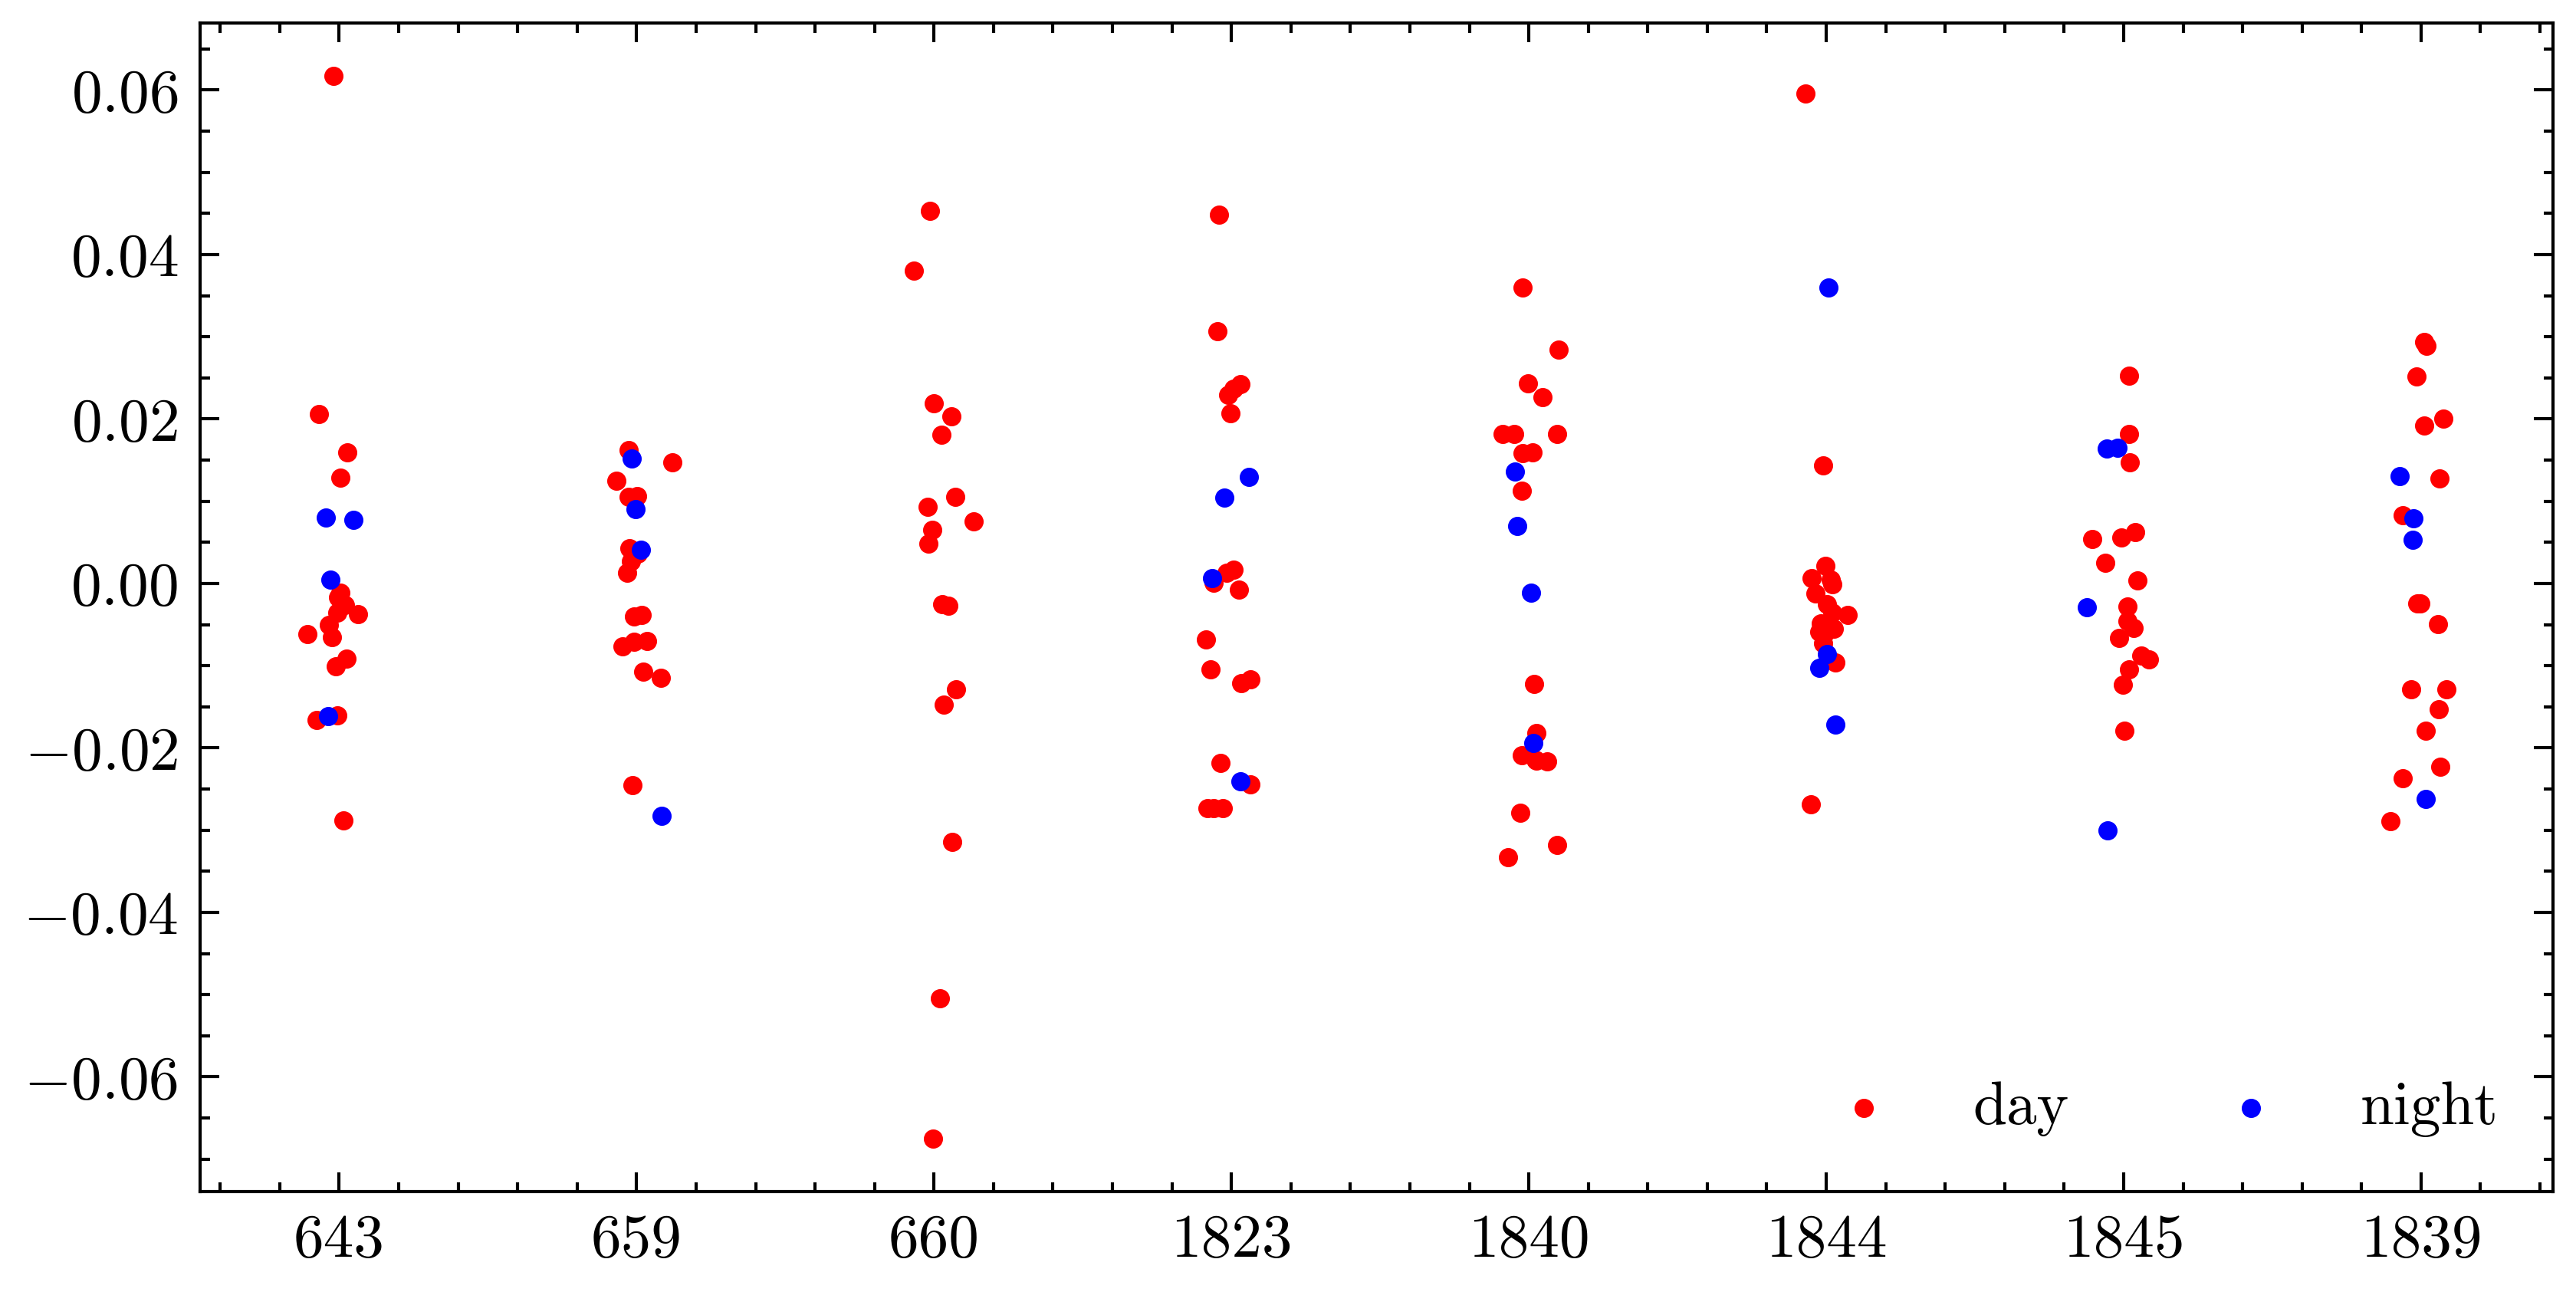

In [29]:
_ = plt.xticks(range(len(mips['day'])), list(mips['day'].keys()))

x_loc = { x : i for i, x in enumerate(list(mips['day'].keys())) }

for color, dir in zip(['red', 'blue'], ['day', 'night']):
    for key, mip in mips[dir].items():
        plt.scatter( x_loc[key] + np.random.normal(scale=0.05, size=len(mip)), (mip - np.mean(mip)) / np.mean(mip), c=color)

    plt.scatter([],[], label=dir, c=color)

plt.xticks(list(x_loc.values()), list(x_loc.keys()))
plt.legend(ncol=2)

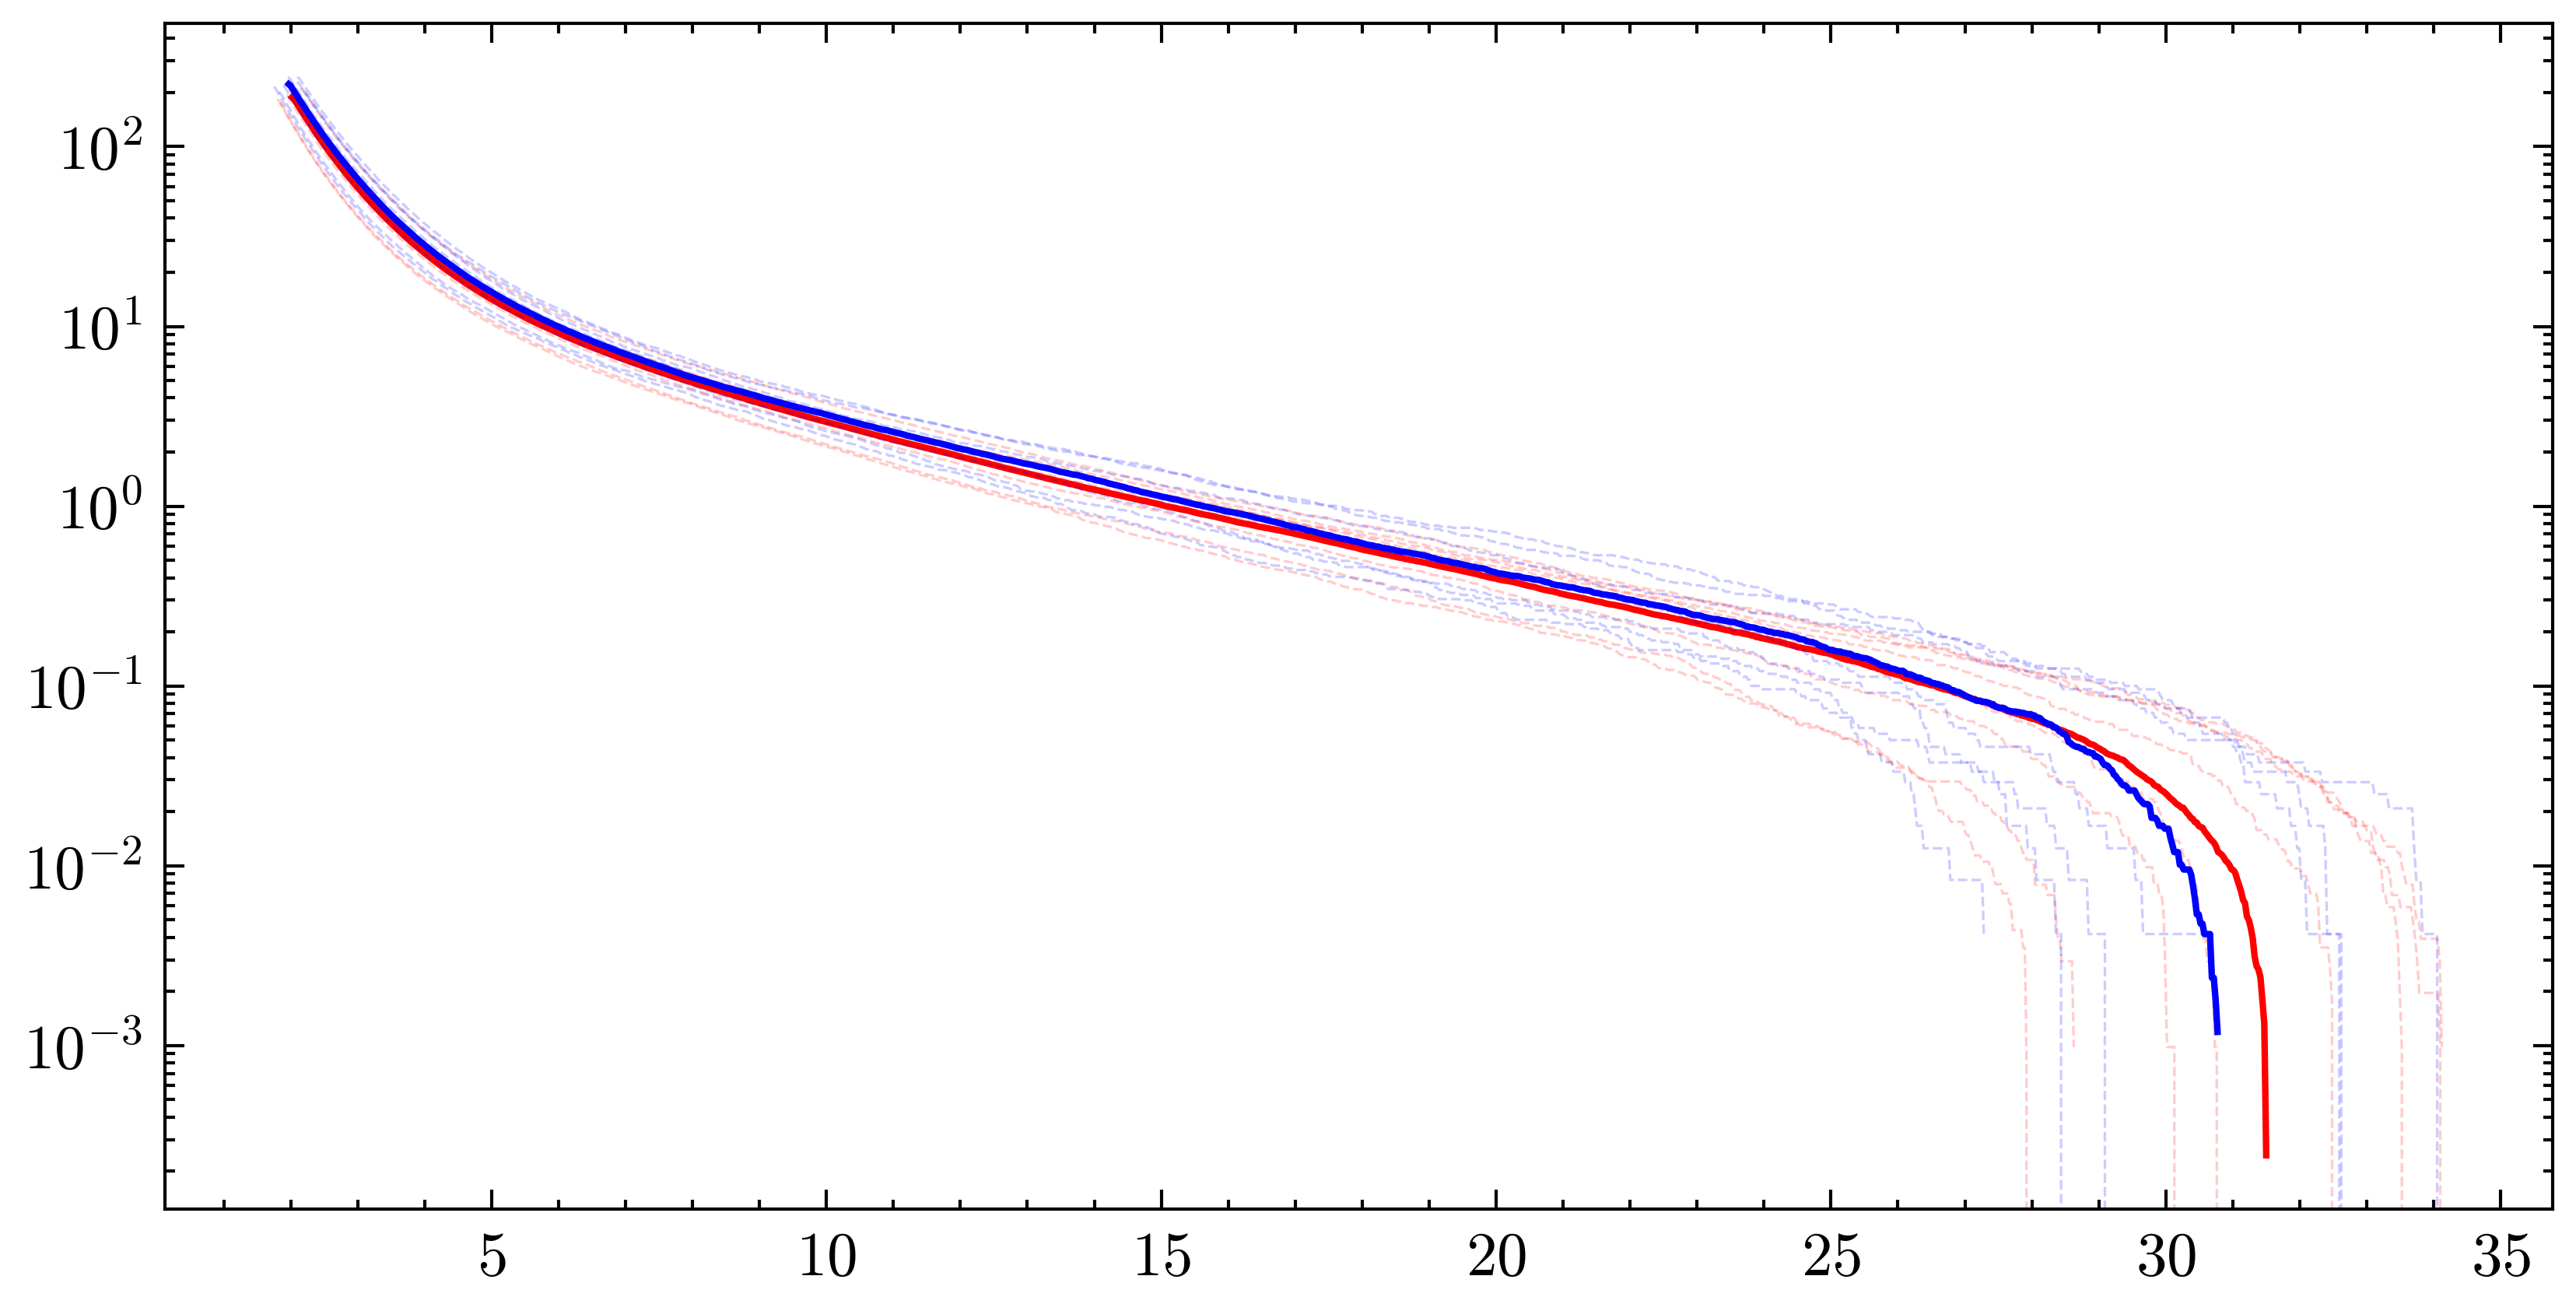

In [31]:

rate_x, rate_y = np.zeros((2, 1024))

for color, directory in zip(['red', 'blue'], ['day', 'night']):

    mean_mean_x, mean_mean_y = np.zeros((2, 1024))

    for key, rate in rates[directory].items():

        mean_x, mean_y = np.zeros((2, 1024))

        for r in rate:
            x = np.arange(r['offset'], r['offset'] + len(r['rate'] + 0.1), 1) / r['mip']
            mean_x += 1/len(rate) * x
            mean_y += 1/len(rate) * r['rate']

        plt.plot(mean_x, mean_y, label=key, ls='--', c=color, lw=0.4, alpha=0.2)

        # # exclude stations with masked PMTs
        # if key in ['643', '659', '1839', '1844']:
        #     plt.plot(mean_x, mean_y, label=key, ls='--', c='k', lw=0.4, alpha=0.9)
        #     continue

        factor = 1/len(rates[directory].keys())
        mean_mean_x += factor * mean_x
        mean_mean_y += factor * mean_y

    rate_x += 0.5 * mean_x
    rate_y += 0.5 * mean_y
    
    plt.plot(mean_mean_x, mean_mean_y, c=color, lw=1, ls='solid')

plt.yscale('log')

np.savetxt('/cr/users/filip/Data/muonAcquisition/mean_rates.txt', np.vstack([rate_x, rate_y]).T)